In [1]:
import tensorflow as tf

tf.__version__

'2.5.0'

In [3]:
import os

input_train_dir = './input/cifar-10/train'

train_image_filenames = [f for f in os.listdir(input_train_dir) if f.endswith('.png')]
len(train_image_filenames)

50000

In [10]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
import pandas as pd
train_labels_df = pd.read_csv('./input/cifar-10/trainLabels.csv')

In [6]:
train_labels_df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [97]:
TRAIN = 'train'
VALIDATION = 'validation'
processed_dir = './processed/cifar-10'
for l in label_names:
    cur_label_train_dir = os.path.join(processed_dir, TRAIN, l)
    cur_label_validation_dir = os.path.join(processed_dir, VALIDATION, l)
    if not os.path.exists(cur_label_train_dir):
        os.makedirs(cur_label_train_dir)
        print(f"Make dir {cur_label_train_dir}")
    if not os.path.exists(cur_label_validation_dir):
        os.makedirs(cur_label_validation_dir)    
        print(f"Make dir {cur_label_validation_dir}")

Make dir ./processed/cifar-10/train/airplane
Make dir ./processed/cifar-10/validation/airplane
Make dir ./processed/cifar-10/train/automobile
Make dir ./processed/cifar-10/validation/automobile
Make dir ./processed/cifar-10/train/bird
Make dir ./processed/cifar-10/validation/bird
Make dir ./processed/cifar-10/train/cat
Make dir ./processed/cifar-10/validation/cat
Make dir ./processed/cifar-10/train/deer
Make dir ./processed/cifar-10/validation/deer
Make dir ./processed/cifar-10/train/dog
Make dir ./processed/cifar-10/validation/dog
Make dir ./processed/cifar-10/train/frog
Make dir ./processed/cifar-10/validation/frog
Make dir ./processed/cifar-10/train/horse
Make dir ./processed/cifar-10/validation/horse
Make dir ./processed/cifar-10/train/ship
Make dir ./processed/cifar-10/validation/ship
Make dir ./processed/cifar-10/train/truck
Make dir ./processed/cifar-10/validation/truck


In [98]:
import shutil

train_prefix = os.path.join(processed_dir, TRAIN)
validation_prefix = os.path.join(processed_dir, VALIDATION)

N = len(train_labels_df)
used = N
# used = 3000
pivot = round(used * 0.8)


df = train_labels_df.sample(frac = 1, random_state = 0)

for i in range(used):
    prefix = train_prefix
    if i > pivot:
        prefix = validation_prefix
    cur_id = df.iloc[i].id
    cur_label = df.iloc[i].label
    # print(f'id: {cur_id} label: {cur_label}')
    img_file = os.path.join(input_train_dir, str(cur_id) + '.png')
    target_dir = os.path.join(prefix, cur_label)
    # print(f'Copy: {img_file} to {target_dir}')
    shutil.copy(img_file, target_dir)

In [99]:
total_train = 0
total_validation = 0
for l in label_names:
    n_train = len(os.listdir(os.path.join(train_prefix, l)))
    n_validation = len(os.listdir(os.path.join(validation_prefix, l)))
    total_train += n_train
    total_validation += n_validation
    print(f'{l:>10}\t# trains: {n_train:>5}\t\t# validation: { n_validation:>5}')
    
total_train, total_validation

  airplane	# trains:  3995		# validation:  1005
automobile	# trains:  4003		# validation:   997
      bird	# trains:  3981		# validation:  1019
       cat	# trains:  4008		# validation:   992
      deer	# trains:  4006		# validation:   994
       dog	# trains:  3979		# validation:  1021
      frog	# trains:  4021		# validation:   979
     horse	# trains:  4014		# validation:   986
      ship	# trains:  3941		# validation:  1059
     truck	# trains:  4053		# validation:   947


(40001, 9999)

In [111]:
batch_size = 256
image_shape = 32

In [132]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# https://keras.io/api/preprocessing/image/
image_gen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 25,
    zoom_range = 0.1,
    horizontal_flip = True,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.1,
)
train_data_gen = image_gen.flow_from_directory(
    batch_size = batch_size,
    directory = train_prefix,
    shuffle = True,
    target_size = (image_shape, image_shape),
    class_mode = 'sparse',
)

Found 40001 images belonging to 10 classes.


In [133]:
import matplotlib.pyplot as plt

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize = (20 ,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

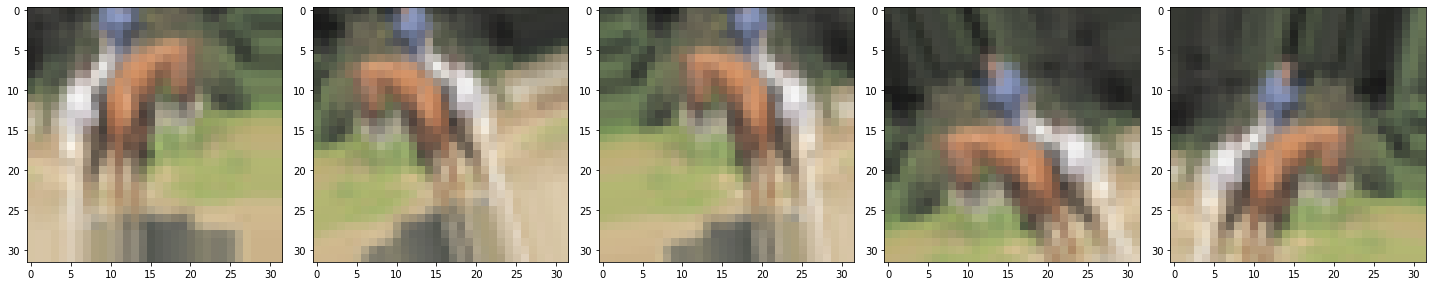

In [134]:
plot_images([train_data_gen[0][0][0] for i in range(5)])

In [135]:
image_gen = ImageDataGenerator(
    rescale = 1. / 255,
)
validation_data_gen = image_gen.flow_from_directory(
    batch_size = batch_size,
    directory = validation_prefix,
    target_size = (image_shape, image_shape),
    class_mode = 'sparse',
)

Found 9999 images belonging to 10 classes.


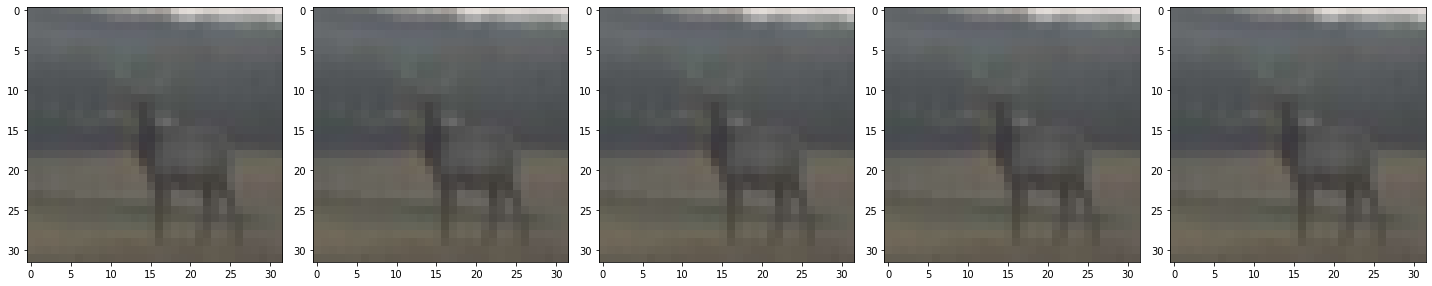

In [136]:
plot_images([validation_data_gen[0][0][0] for i in range(5)])

In [185]:
from tensorflow.keras import layers, losses, models

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (image_shape, image_shape, 3)),
    layers.MaxPooling2D(2, 2),
#    layers.Dropout(0.3),
    
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(256, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2, 2),
#    layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(len(label_names), activation = 'relu'),
])

In [186]:
"""
model = models.Sequential([
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (image_shape, image_shape, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),
  
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.3),
    
    layers.Dense(len(label_names), activation = 'relu'),
])
"""

"\nmodel = models.Sequential([\n    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (image_shape, image_shape, 3)),\n    layers.MaxPooling2D(2, 2),\n    layers.Dropout(0.3),\n    \n    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),\n    layers.MaxPooling2D(2, 2),\n    layers.Dropout(0.3),\n    \n    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),\n    layers.MaxPooling2D(2, 2),\n    layers.Dropout(0.3),\n  \n    layers.Flatten(),\n    layers.Dense(64, activation = 'relu'),\n    layers.Dropout(0.3),\n    layers.Dense(64, activation = 'relu'),\n    layers.Dropout(0.3),\n    \n    layers.Dense(len(label_names), activation = 'relu'),\n])\n"

In [187]:
"""
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (image_shape, image_shape, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
  
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.2),
    
    layers.Dense(len(label_names)),
])
"""

"\nmodel = models.Sequential([\n    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (image_shape, image_shape, 3)),\n    layers.MaxPooling2D(2, 2),\n    layers.Dropout(0.2),\n    \n    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),\n    layers.MaxPooling2D(2, 2),\n    layers.Dropout(0.2),\n  \n    layers.Flatten(),\n    layers.Dense(128, activation = 'relu'),\n    layers.Dropout(0.2),\n    \n    layers.Dense(len(label_names)),\n])\n"

In [188]:
"""
model = models.Sequential([
    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu', input_shape = (image_shape, image_shape, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
  
    layers.Flatten(),
    layers.Dense(512, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(0.2),
    
    layers.Dense(len(label_names)),
])
"""

"\nmodel = models.Sequential([\n    layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu', input_shape = (image_shape, image_shape, 3)),\n    layers.MaxPooling2D(2, 2),\n    layers.Dropout(0.2),\n    \n    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),\n    layers.MaxPooling2D(2, 2),\n    layers.Dropout(0.2),\n    \n    layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),\n    layers.MaxPooling2D(2, 2),\n    layers.Dropout(0.2),\n  \n    layers.Flatten(),\n    layers.Dense(512, activation = 'relu'),\n    layers.Dropout(0.2),\n    layers.Dense(256, activation = 'relu'),\n    layers.Dropout(0.2),\n    \n    layers.Dense(len(label_names)),\n])\n"

In [189]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    patience = 5,
    min_delta = 0.001,
    restore_best_weights = True,
)

In [190]:
import numpy as np

model.compile( 
    'adam',
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy'],
)

epochs = 500

tf.random.set_seed(1)
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch = int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs = epochs,
    validation_data = validation_data_gen,
    validation_steps = int(np.ceil(validation_data_gen.n / float(batch_size))),
    callbacks = [early_stopping],
)

/usr/local/Cellar/jupyterlab/3.0.16_1/libexec/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
157/157 [==============================] - 41s 261ms/step - loss: 2.0731 - accuracy: 0.2735 - val_loss: 2.1962 - val_accuracy: 0.2318
Epoch 2/500
157/157 [==============================] - 40s 254ms/step - loss: 1.6901 - accuracy: 0.3934 - val_loss: 1.8055 - val_accuracy: 0.3838
Epoch 3/500
157/157 [==============================] - 42s 266ms/step - loss: 1.5265 - accuracy: 0.4524 - val_loss: 1.3561 - val_accuracy: 0.5377
Epoch 4/500
157/157 [==============================] - 44s 283ms/step - loss: 1.4215 - accuracy: 0.4935 - val_loss: 2.3112 - val_accuracy: 0.3426
Epoch 5/500
157/157 [==============================] - 42s 267ms/step - loss: 1.3466 - accuracy: 0.5208 - val_loss: 1.3734 - val_accuracy: 0.5395
Epoch 6/500
157/157 [==============================] - 40s 255ms/step - loss: 1.2802 - accuracy: 0.5477 - val_loss: 1.1871 - val_accuracy: 0.5985
Epoch 7/500
157/157 [==============================] - 40s 256ms/step - loss: 1.2351 - accuracy: 0.5656 - val_loss: 1.2828 -

Validation accuracy max: 0.7575757503509521


<AxesSubplot:title={'center':'Accuracy'}>

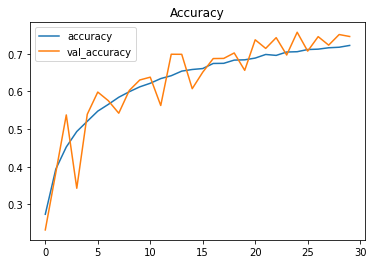

In [191]:
history_df = pd.DataFrame(history.history)

print(f"Validation accuracy max: {history_df.val_accuracy.max()}")

history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy')

In [192]:
def read_images(images_path):
    files = [f for f in os.listdir(images_path)]
    images_df = pd.DataFrame()

    for i in range(len(files)):
        if files[i].endswith('png'):
            img = plt.imread(os.path.join(images_path, files[i]))
            img_number = int(files[i].split('.')[0])
            images_df = images_df.append({'id': img_number, 'img': img}, ignore_index = True)
            
    images_df.sort_values(by=['id'], inplace = True)
    return np.array(list(images_df.img))

test_images = read_images('./input/cifar-10/test')

In [193]:
test_images.shape

(300000, 32, 32, 3)

In [194]:
predictions = model.predict(test_images)

test_labels = list(map(np.argmax, predictions))
test_labels = list(map(lambda x: label_names[x], test_labels))

In [195]:
output = pd.DataFrame({'id': range(1, len(test_labels)+1), 'label': test_labels})
output.to_csv("cnn_img_aug_submission.csv", index = False)

# Reference

[Codelab for Dogs v.s. Cats with Image Augmentation](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c02_dogs_vs_cats_with_augmentation.ipynb)

[UD187 - Intro to TensorFlow for Deep Learning - Lession 5 Going Further With CNNS](https://classroom.udacity.com/courses/ud187)